# ChromVAR

Run ChromVAR manually.

In [1]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(ggseqlogo)
library(BiocParallel)
set.seed(2020)



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

In [2]:
register(MulticoreParam(20, progressbar = TRUE))

In [3]:
# PFM_DIR = './data/neurallike_modisco/'
# PFM_DIR = '../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/'
# PFM_FILES = list.files(PFM_DIR)
# PFM_NAMES = lapply(strsplit(PFM_FILES, "\\."), "[[", 1)
# PFM_FILES = paste(PFM_DIR, PFM_FILES, sep='')
# PFM_NAMES
# PFM_FILES

In [4]:
get_rev_comp <- function(motif_pfm) {
    motif_pfm = motif_pfm[, rev(seq(1,ncol(motif_pfm)))]
    
    stopifnot(rownames(motif_pfm)==c("A","C","G","T"))
    rownames(motif_pfm) = c("T", "G", "C", "A")
    
    motif_pfm = motif_pfm[c("A","C","G","T"), ]
}

load_motif <- function(pfm_path, max_width=20) {
    stopifnot(max_width%%2==0)
    
    # loads motif in a canonical form such that A,C are maximised
    motif_pfm = t(as.matrix(read.table(pfm_path)))
    rownames(motif_pfm) = c("A", "C", "G", "T")
    
    if (ncol(motif_pfm)>max_width) {
        # roughly estimate "center of mass"
        center = as.integer(sum(colMaxs(motif_pfm)*seq(1,ncol(motif_pfm)))/sum(colMaxs(motif_pfm)))
        start = center - (max_width/2)
        end = center + (max_width/2) - 1
        
        if (start < 1) {
            start = 1
            end = max_width
        }
        
        else if (end > ncol(motif_pfm)) {
            end = ncol(motif_pfm)
            start = end - max_width + 1
        }
        
        motif_pfm = motif_pfm[, start:end]
    }
    
    rev_comp_pfm = get_rev_comp(motif_pfm)
    
    # canonicalize (A/C content in first half of motif)
    if (sum(rev_comp_pfm[c("A","C"),1:floor(ncol(rev_comp_pfm)/2)])>sum(motif_pfm[c("A","C"),1:floor(ncol(motif_pfm)/2)])) {
        motif_pfm = rev_comp_pfm
    }
    
    motif_pfm
}

In [5]:
# MAX_MOTIF_LEN = 30
# pfms = list()

# for (i in seq(length(PFM_FILES))) {
#     cur_pfm = load_motif(PFM_FILES[i])
#     pfms[[i]] = PFMatrix(ID=unlist(PFM_NAMES[i]),
#                         name=unlist(PFM_NAMES[i]),
#                         bg=c(A=0.25, C=0.25, G=0.25, T=0.25),
#                         profileMatrix=cur_pfm)
# }

In [6]:
# motifs = do.call(PFMatrixList, c(pfms, use.names=T))
# motifs

In [7]:
# to_plot = lapply(pfms, as.matrix)
# names(to_plot) = lapply(pfms, function(x) {x@ID})

In [8]:
# names(to_plot)

In [9]:
# options(repr.plot.width = 10, repr.plot.height = 10)
# ggseqlogo(to_plot, ncol=3) +
#     theme(axis.text.x = element_blank(),
#          axis.text.y = element_blank(),
#          axis.title.y = element_blank())

In [12]:
# options(repr.plot.width = 10, repr.plot.height = 5)
# ggseqlogo(list(to_plot[[2]][,19:33], get_rev_comp(to_plot[[13]])[,16:30]), ncol=1) +
# theme(axis.text.x = element_blank(),
#          axis.text.y = element_blank(),
#          axis.title.y = element_blank(),plot.title=element_blank())

In [10]:
# motif_names = c()
# for (i in seq(length(motifs))) {
#     motif_names = c(motif_names, name(motifs[[i]]))
# }
# motif_names

### Or Load Precomputed Peaks x Motif Hits Matrix

In [11]:
motifs_bpnet_hits = readMM("../20211007_motif_consolidation/consolidated/20210820_chrombpnet_lite/peaks_x_importance_thresholded.mm")

In [12]:
dim(motifs_bpnet_hits)

[1] 530910     30

In [13]:
motif_bpnet_hits_names = read.table("../20211007_motif_consolidation/consolidated/20210820_chrombpnet_lite/tfs_final.txt")
motif_bpnet_hits_names = as.character(unlist(motif_bpnet_hits_names$V1))

In [14]:
length(motif_bpnet_hits_names)

[1] 30

In [15]:
motif_bpnet_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = motifs_bpnet_hits), 
                 colData = DataFrame(name=motif_bpnet_hits_names)
    );

### Or use JASPAR

In [16]:
# motifs <- getJasparMotifs()

In [17]:
# x = grep("ZEB", names(motifs))
# motifs = motifs[x]
# motifs

## Load Data

In [18]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20210717_n62599/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  62599 530910

In [19]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) 
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


In [20]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 530910      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr17_32960817_32961317,chr17,32960817,32961317,chr17_32960817_32961317
chr17_75764252_75764752,chr17,75764252,75764752,chr17_75764252_75764752
chr17_1473114_1473614,chr17,1473114,1473614,chr17_1473114_1473614
chr17_4206897_4207397,chr17,4206897,4207397,chr17_4206897_4207397
chr17_423409_423909,chr17,423409,423909,chr17_423409_423909
chr17_1964634_1965134,chr17,1964634,1965134,chr17_1964634_1965134


In [21]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 530910 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 32960817-32961317      *
       [2]    chr17 75764252-75764752      *
       [3]    chr17   1473114-1473614      *
       [4]    chr17   4206897-4207397      *
       [5]    chr17     423409-423909      *
       ...      ...               ...    ...
  [530906]     chrY   7260941-7261441      *
  [530907]     chrY 13337357-13337857      *
  [530908]     chrY   7109991-7110491      *
  [530909]     chrY 13241191-13241691      *
  [530910]     chrY   7936006-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [22]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [23]:
pmatRowSums = Matrix::rowSums(pmat)

In [24]:
pmatColSums = Matrix::colSums(pmat)

In [19]:
min(pmatRowSums)

[1] 222

In [20]:
min(pmatColSums)

[1] 15

## ChromVAR

In [25]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [26]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [27]:
rse <- addGCBias(rse, genome = GENOME);

---
Match motifs

In [24]:
# motif_mm <- matchMotifs(motifs, rse, genome = GENOME)

Or use pre-computed matrix, e.g. from BPNet hits loaded above

In [28]:
motif_mm <- motif_bpnet_hits_se

---

In [29]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_mm$name

In [30]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



In [31]:
dev_mat = t(assay(dev))

In [32]:
colnames(dev_mat) = motif_mm$name
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

,REST_MA0138.2,CTCF_MA0139.1,ZN143_MOUSE.H11MO.0.A,NFYB_HUMAN.H11MO.0.A,SIX1_HUMAN.H11MO.0.A,IRF1_MA0050.2,MEF2D_MOUSE.H11MO.0.A,PO5F1_MOUSE.H11MO.0.A,TEAD1_TEA_2,NFIC_HUMAN.H11MO.0.A,⋯,TWST1_MOUSE.H11MO.0.B,FOXC2_MA0846.1,NFKB1_HUMAN.H11MO.1.B,AP2A_MOUSE.H11MO.0.A,POU3F2_MA0787.1,EGR2_MOUSE.H11MO.0.A,COE1_HUMAN.H11MO.0.A,SOX15_MA1152.1,SP2_HUMAN.H11MO.0.A,KLF3_HUMAN.H11MO.0.B
D0_AAACACGCTAGTACGG,-0.03992983,-0.09110392,0.01874790,-0.016624187,0.070664493,0.04794643,0.1126609,-0.5661542,-0.08500272,0.08653619,⋯,0.1508525,0.2594324,-0.233405040,-0.1882389,-0.5373140,-0.08072861,-0.11681020,-0.5002310,-0.06682920,-0.09505564
D0_AAACACGCTCTTCAAG,-0.09213646,-0.15573448,-0.15160631,0.004342086,0.052756741,0.24809007,0.6195817,-0.4541400,0.02547614,0.17602830,⋯,0.4129283,0.3622910,0.006284052,-0.2426729,-0.4758716,-0.09477851,0.09168831,-0.2195730,-0.10223812,-0.11542050
D0_AAACACGCTGATCCAT,-0.09161501,-0.12736457,-0.08825900,-0.029893118,0.016185847,0.16957763,0.3249433,-0.5460399,-0.08881455,0.11244850,⋯,0.1396287,0.1193892,-0.079016180,-0.2214509,-0.5234648,-0.09766669,-0.16529088,-0.4045625,-0.09995258,-0.13051261
D0_AAACCCTGACCGCTAG,0.02267605,-0.24379314,-0.02047937,-0.016131096,-0.003989692,0.16896416,0.6984250,-0.5471426,0.01885561,0.14780240,⋯,0.3551428,0.2458761,0.013426444,-0.1472500,-0.4431962,-0.07695787,-0.14326061,-0.3775057,-0.06986305,-0.08775686
D0_AAACCCTGATTGCAGT,-0.19516841,-0.18508335,-0.08373697,-0.115402190,-0.036267333,0.12288117,0.9210576,-0.4200498,0.47632013,0.07760780,⋯,0.4317622,0.2041619,-0.187833304,-0.2793195,-0.5160956,-0.03482673,-0.05389457,-0.2760945,-0.07233157,-0.08893173
D0_AAACCGTACACACCTA,-0.03709587,-0.13791054,-0.02919290,-0.024943411,0.012423244,0.20373593,0.3947431,-0.5407774,0.20471106,0.11242010,⋯,0.2619757,0.2195257,-0.025867266,-0.1727469,-0.4643478,-0.08790542,-0.14150442,-0.3910098,-0.08781413,-0.11380452


In [99]:
# save output
# write.table(dev_mat, file="./out/20210717_n62599/20211007_importance_thresholded.tsv", quote=F, row.names=T, sep='\t')

In [84]:
variability <- computeVariability(dev)

  |======================================================================| 100%



In [85]:
head(variability)

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,REST_MA0138.2,1.415581,1.407184,1.423385,0,0
2,CTCF_MA0139.1,7.768107,7.696617,7.834362,0,0
3,ZN143_MOUSE.H11MO.0.A,1.818160,1.808275,1.827768,0,0
4,NFYB_HUMAN.H11MO.0.A,2.065358,2.048229,2.081609,0,0
5,SIX1_HUMAN.H11MO.0.A,2.589515,2.571342,2.609122,0,0
6,IRF1_MA0050.2,1.975692,1.962502,1.988659,0,0


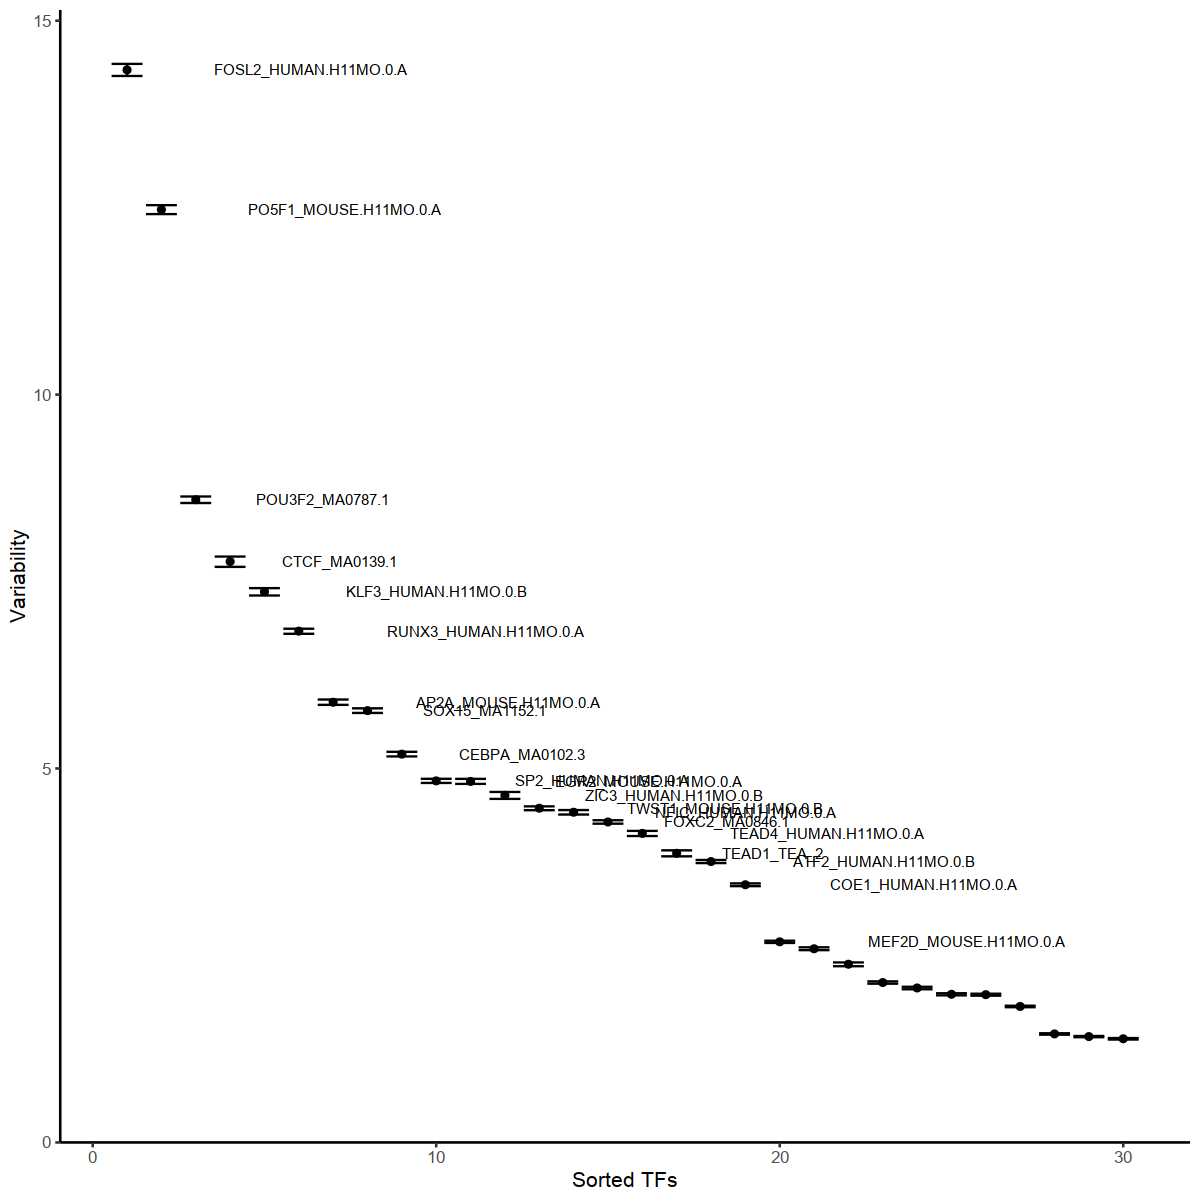

In [86]:
plotVariability(variability, use_plotly = FALSE, n = 20) 

In [87]:
variability[rev(order(variability$variability)), "name"]

[1] FOSL2_HUMAN.H11MO.0.A PO5F1_MOUSE.H11MO.0.A POU3F2_MA0787.1      
 [4] CTCF_MA0139.1         KLF3_HUMAN.H11MO.0.B  RUNX3_HUMAN.H11MO.0.A
 [7] AP2A_MOUSE.H11MO.0.A  SOX15_MA1152.1        CEBPA_MA0102.3       
[10] SP2_HUMAN.H11MO.0.A   EGR2_MOUSE.H11MO.0.A  ZIC3_HUMAN.H11MO.0.B 
[13] TWST1_MOUSE.H11MO.0.B NFIC_HUMAN.H11MO.0.A  FOXC2_MA0846.1       
[16] TEAD4_HUMAN.H11MO.0.A TEAD1_TEA_2           ATF2_HUMAN.H11MO.0.B 
[19] COE1_HUMAN.H11MO.0.A  MEF2D_MOUSE.H11MO.0.A SIX1_HUMAN.H11MO.0.A 
[22] GRHL1_CP2_1           ETS1_MOUSE.H11MO.0.A  NFYB_HUMAN.H11MO.0.A 
[25] NFKB1_HUMAN.H11MO.1.B IRF1_MA0050.2         ZN143_MOUSE.H11MO.0.A
[28] NRF1_HUMAN.H11MO.0.A  REST_MA0138.2         RFX2_MOUSE.H11MO.0.A 
30 Levels: AP2A_MOUSE.H11MO.0.A ATF2_HUMAN.H11MO.0.B ... ZN143_MOUSE.H11MO.0.A

In [164]:
colnames(dev_mat)[grep("ZIC", colnames(dev_mat))]

[1] "ZIC3_HUMAN.H11MO.0.B"

In [165]:
cur_pattern = "ZIC3_HUMAN.H11MO.0.B"

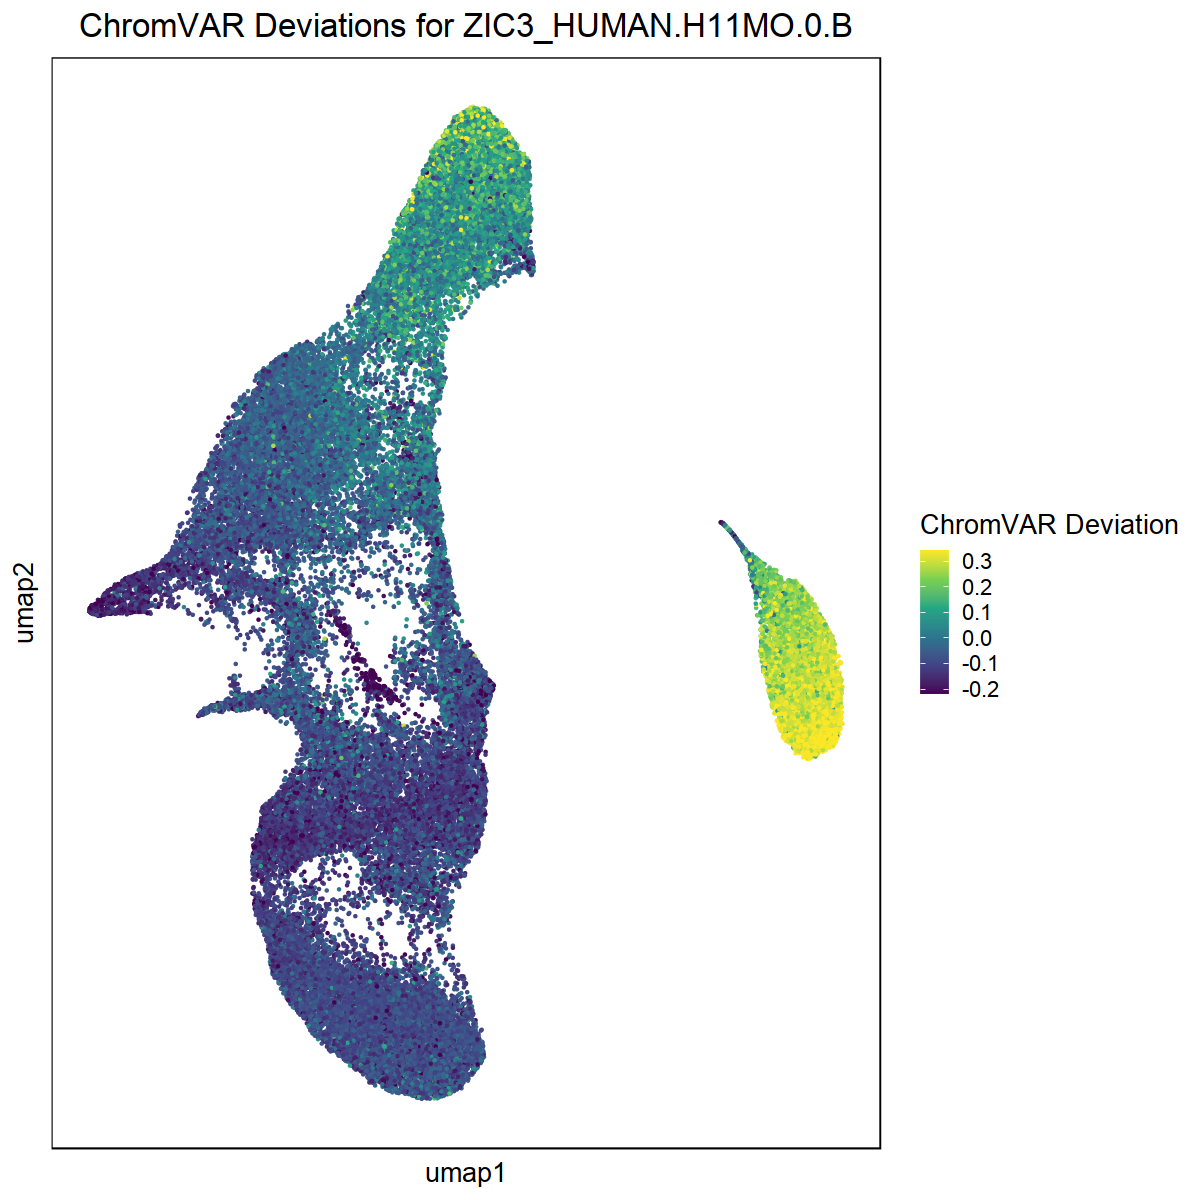

In [166]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.02),
                              quantile(cur_dev, 0.98)), 
                      oob = squish, name='ChromVAR Deviation') +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme_classic(base_size = 16) +
theme(plot.title = element_text(hjust = 0.5),
     axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
     panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

# ggsave("tmp.png", height=10, width=10)

In [167]:
sum(motif_mm_mat[, cur_pattern])

[1] 38553

In [168]:
frip = 100*Matrix::rowSums(pmat[, which(motif_mm_mat[, cur_pattern])])/pmatRowSums

In [169]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.9522075

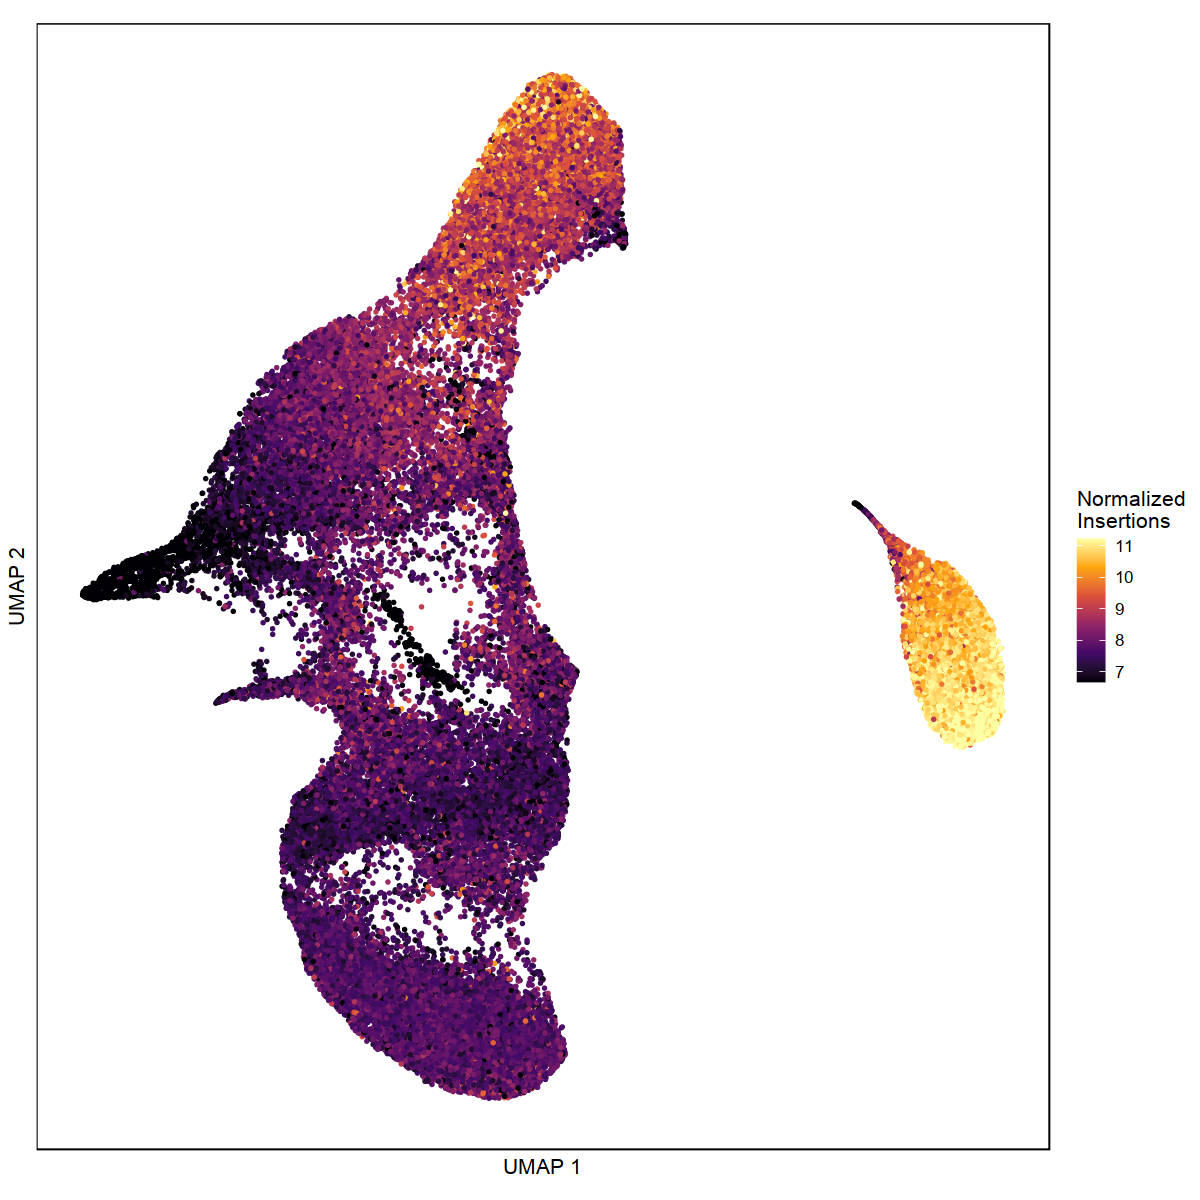

In [170]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.05),
                              quantile(frip, 0.98)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

---

### SessionInfo

In [104]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggseqlogo_0.1                     scales_1.1.0                     
 [3] ggplot2_3.3.3                     motifmatchr_1.8.0                
 [5] SummarizedExperiment_1.16.1       DelayedArray_0.12.3              
 [7] BiocParallel_1.20.1               matrixStats_0.56.